In [39]:
#Importando bibliotecas

import numpy as np

import torch
import torch.nn as nn
    
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader

from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torch.nn as nn
import plotly.graph_objects as go

# CPC SSL Training

In [40]:
data_path = Path('data/TNC/HAR_data')
x_train = np.load(data_path/'x_train.npy')
y_train = np.load(data_path/'y_train.npy')
x_test = np.load(data_path/'x_test.npy')
y_test = np.load(data_path/'y_test.npy')

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21, 561, 281), (21, 281), (9, 561, 288), (9, 288))

In [41]:
# Resume todos os vetores z em em único vetor de contexto​

class GRUEncoder(torch.nn.Module):
    def __init__(
        self,
        hidden_size: int = 100,
        in_channel: int = 561,
        encoding_size: int = 10,
        num_layers: int = 1,
        dropout: float = 0.0,
        bidirectional: bool = True,
        device: str = "cpu",
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.in_channel = in_channel
        self.num_layers = num_layers
        self.encoding_size = encoding_size
        self.bidirectional = bidirectional
        self.device = device
        
        self.rnn = torch.nn.GRU(
            input_size=self.in_channel,
            hidden_size=self.hidden_size,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout,
            bidirectional=bidirectional,
        ).to(device) 

        self.nn = torch.nn.Linear(
            self.hidden_size * (int(self.bidirectional) + 1), self.encoding_size
        ).to(device)

    def forward(self, x):
        x = x.permute(2, 0, 1)

        past = torch.zeros(
            self.num_layers * (int(self.bidirectional) + 1),
            x.shape[1],
            self.hidden_size,
            device=self.device,
        )

        out, _ = self.rnn(
            x, past
        )  # out shape = [seq_len, batch_size, num_directions*hidden_size]
        encodings = self.nn(out[-1].squeeze(0))
        return encodings

### TNC Training Module

The SSL routine used to train the encoder

In [42]:
class CPC(pl.LightningModule):
    def __init__(
        self,
        encoder: torch.nn.Module,
        density_estimator: torch.nn.Module,
        auto_regressor: torch.nn.Module,
        lr: float = 1e-3,
        weight_decay: float = 0.0,
        window_size: int = 4,
        n_size: int = 5
    ):
        super().__init__()
        self.encoder = encoder.to(self.device)
        self.density_estimator = density_estimator.to(self.device)
        self.auto_regressor = auto_regressor.to(self.device)
        self.learning_rate = lr
        self.weight_decay = weight_decay
        self.window_size = window_size
        self.n_size = n_size
        self.training_step_losses = []
        self.train_epoch_loss = []


    def training_step(self, batch, batch_idx):
        assert len(batch) == 1, "Batch must be 1 sample only"
        sample = batch
        sample = sample.squeeze(0)
        rnd_t = np.random.randint(
            5 * self.window_size, sample.shape[-1] - 5 * self.window_size
        )
        sample = torch.tensor(
            sample[
                :,
                max(0, (rnd_t - 20 * self.window_size)) : min(
                    sample.shape[-1], rnd_t + 20 * self.window_size
                ),
            ]
        ).cpu()

        T = sample.shape[-1]
        windowed_sample = np.split(
            sample[:, : (T // self.window_size) * self.window_size],
            (T // self.window_size),
            -1,
        )
        windowed_sample = torch.tensor(np.stack(windowed_sample, 0), device=self.device)
        encodings = self.encoder(windowed_sample)
        window_ind = torch.randint(2, len(encodings) - 2, size=(1,))
        _, c_t = self.auto_regressor(
            encodings[max(0, window_ind[0] - 10) : window_ind[0] + 1].unsqueeze(0)
        )
        density_ratios = torch.bmm(
            encodings.unsqueeze(1),
            self.density_estimator(c_t.squeeze(1).squeeze(0)).expand_as(encodings).unsqueeze(-1),
        ).view(
            -1,
        )
        r = set(range(0, window_ind[0] - 2))
        r.update(set(range(window_ind[0] + 3, len(encodings))))
        rnd_n = np.random.choice(list(r), self.n_size)
        X_N = torch.cat(
            [density_ratios[rnd_n], density_ratios[window_ind[0] + 1].unsqueeze(0)], 0
        )
        labels = torch.Tensor([len(X_N) - 1]).to(self.device)
        loss = torch.nn.CrossEntropyLoss()(X_N.view(1, -1), labels.long())
        self.training_step_losses.append(loss)
        return loss


    def on_train_epoch_end(self) -> None:
        # do something with all training_step outputs, for example:
        epoch_mean = torch.stack(self.training_step_losses).mean()
        self.train_epoch_loss.append(epoch_mean.cpu().detach().numpy())
        self.log("train_loss", epoch_mean, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        # free up the memory
        self.training_step_losses.clear()
        
    def configure_optimizers(self):
        learnable_parameters = (
            list(self.density_estimator.parameters())
            + list(self.encoder.parameters())
            + list(self.auto_regressor.parameters())
        )

        optimizer = torch.optim.Adam(
            learnable_parameters, lr=self.learning_rate, weight_decay=self.weight_decay
        )
        return optimizer

In [43]:
encoding_size = 10
encoder = GRUEncoder(encoding_size=10, device='cuda')
density_estimator = torch.nn.Linear(encoding_size, encoding_size)
auto_regressor = torch.nn.GRU(
    input_size=encoding_size, 
    hidden_size=encoding_size, 
    batch_first=True
)

cpc = CPC(encoder, density_estimator, auto_regressor)

In [44]:
class SimpleDataset:
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx].astype(np.float32), self.y[idx].astype(np.float32)
        else:
            return self.X[idx].astype(np.float32)
    
train_dataset = SimpleDataset(x_train)
test_dataset = SimpleDataset(x_test, y_test)
len(train_dataset), len(test_dataset)

(21, 9)

In [45]:
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=10, shuffle=False)

In [46]:
trainer = pl.Trainer(max_epochs=500, accelerator="gpu", devices=1)

True

In [47]:
trainer.fit(cpc, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name              | Type       | Params
-------------------------------------------------
0 | encoder           | GRUEncoder | 399 K 
1 | density_estimator | Linear     | 110   
2 | auto_regressor    | GRU        | 660   
-------------------------------------------------
400 K     Trainable params
0         Non-trainable params
400 K     Total params
1.602     Total estimated model params size (MB)


Epoch 0:  76%|███████▌  | 16/21 [00:00<00:00, 80.78it/s, v_num=134]

/tmp/ipykernel_3115364/3311096431.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(


Epoch 2:   0%|          | 0/21 [00:00<?, ?it/s, v_num=134, train_loss=1.840]         

Epoch 499: 100%|██████████| 21/21 [00:00<00:00, 39.71it/s, v_num=134, train_loss=0.935]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 21/21 [00:00<00:00, 32.28it/s, v_num=134, train_loss=0.935]


## CPC Fine-Tuning

We are going to fine-tune the CPC model on the downstream task of classification. We will use the same dataset and re-use the same encoder.

In [48]:
from typing import Any, Optional

from torchmetrics.functional import accuracy


class StateClassifier(torch.nn.Module):
    def __init__(self, input_size: int = 10, n_classes: int = 6):
        super(StateClassifier, self).__init__()
        self.input_size = input_size
        self.n_classes = n_classes
        self.normalize = torch.nn.BatchNorm1d(self.input_size)
        self.nn = torch.nn.Linear(self.input_size, self.n_classes)
        torch.nn.init.xavier_uniform_(self.nn.weight)

    def forward(self, x):
        x = self.normalize(x)
        logits = self.nn(x)
        return logits


class CPC_Classifier(pl.LightningModule):
    def __init__(
        self,
        encoder: torch.nn.Module,
        classifier: torch.nn.Module,
        lr: float = 1e-1,
        weight_decay: float = 0.0,
        task_class: str = "multiclass",
        num_classes: int = 6
    ):
        super().__init__()
        self.encoder = encoder.to(self.device)
        self.classifier = classifier.to(self.device)
        self.learning_rate = lr
        self.weight_decay = weight_decay
        self.training_step_losses = []
        self.validation_step_losses = []
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.task_class = task_class
        self.num_classes = num_classes
        
        self.train_epoch_loss = []
        self.train_epoch_acc = []
        self.val_epoch_loss = []
        self.val_epoch_acc = []
        
    def configure_optimizers(self) -> Any:
        optimizer = torch.optim.Adam(
            self.classifier.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
        )
        return optimizer
    
    def forward(self, x):
        encodings = self.encoder(x)
        predictions = self.classifier(encodings)
        return predictions
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self.forward(x)
        loss = self.loss_function(predictions, y.long())
        self.training_step_losses.append(loss)
        return loss
    
    def on_train_epoch_end(self) -> None:
        # do something with all training_step outputs, for example:
        epoch_mean = torch.stack(self.training_step_losses).mean()
        self.train_epoch_loss.append(epoch_mean.cpu().detach().numpy())
        self.log("train_loss", epoch_mean, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        # free up the memory
        self.training_step_losses.clear()
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        self.validation_step_losses.append(loss)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics)
        return metrics
    
    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"test_acc": acc, "test_loss": loss}
        self.log_dict(metrics)
        return metrics
        
    def on_validation_epoch_end(self) -> None:
        # do something with all training_step outputs, for example:
        epoch_mean = torch.stack(self.validation_step_losses).mean()
        self.val_epoch_loss.append(epoch_mean.cpu().detach().numpy())
        self.log("val_loss", epoch_mean, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        # free up the memory
        self.validation_step_losses.clear()

    def _shared_eval_step(self, batch, batch_idx):
        x, y = batch
        predictions = self.forward(x)
        loss = self.loss_function(predictions, y.long())
        acc = accuracy(torch.argmax(predictions, dim=1), y.long(), task=self.task_class, num_classes=self.num_classes)
        return loss, acc
    
class ClassifierPrintMetrics(pl.Callback):
    def on_fit_end(self, trainer, pl_module):
        #train_acc = pl_module.train_acc.compute()
        #val_acc = pl_module.val_acc.compute()
        train_loss = pl_module.train_epoch_loss
        print(train_loss)
        val_loss = pl_module.val_epoch_loss
        
        print(f"\ntrain_loss={train_loss}, val_loss={val_loss}")
        
        # plotting train and val loss
        plt.figure(figsize=(6, 4))
        plt.plot(train_loss, label='train_loss')
        plt.plot(val_loss, label='val_loss')
        plt.legend()
        plt.title('Train and Validation Loss')
        plt.savefig('./plots/tnc_classifier_loss.png')
        
        # # plotting train and val acc
        # plt.figure(figsize=(12, 8))
        # plt.plot(train_loss, label='train_loss')
        # plt.plot(val_loss, label='val_loss')
        # plt.legend()
        # plt.title('Train and Validation Loss')
        # plt.savefig('./plots/tnc_classifier_loss.png')


In [49]:
data_path = Path('data/TNC/HAR_data')
x_train = np.load(data_path/'x_train.npy')
y_train = np.load(data_path/'y_train.npy')
x_test = np.load(data_path/'x_test.npy')
y_test = np.load(data_path/'y_test.npy')

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21, 561, 281), (21, 281), (9, 561, 288), (9, 288))

In [50]:
class SimpleDataset:
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx].astype(np.float32), self.y[idx].astype(np.float32)
        else:
            return self.X[idx].astype(np.float32)
        
# train_dataset = SimpleDataset(x_train)
# test_dataset = SimpleDataset(x_test, y_test)
# len(train_dataset), len(test_dataset)

In [28]:

# This code as taken from the authors

def create_simulated_dataset(
    X_train, Y_train, X_test, Y_test, window_size=50, batch_size=100
):
    n_train = int(0.8 * len(X_train))
    n_valid = len(X_train) - n_train
    n_test = len(X_test)
    x_train, y_train = X_train[:n_train], Y_train[:n_train]
    x_valid, y_valid = X_train[n_train:], Y_train[n_train:]
    x_test, y_test = X_test, Y_test

    datasets = []
    for x, y, size in [
        (x_train, y_train, n_train),
        (x_test, y_test, n_test),
        (x_valid, y_valid, n_valid),
    ]:
        T = x.shape[-1]
        windows = np.split(
            x[:, :, : window_size * (T // window_size)], (T // window_size), -1
        )
        windows = np.concatenate(windows, 0)
        labels = np.split(
            y[:, : window_size * (T // window_size)], (T // window_size), -1
        )
        labels = np.round(np.mean(np.concatenate(labels, 0), -1))
        datasets.append(SimpleDataset(windows, labels))

    trainset, testset, validset = datasets[0], datasets[1], datasets[2]
    print(f'dataset sizes: train={len(trainset)}, test={len(testset)}, valid={len(validset)}')
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

    return train_loader, valid_loader, test_loader

train_loader, valid_loader, test_loader = create_simulated_dataset(x_train, y_train, x_test, y_test, window_size=4, batch_size=100)

dataset sizes: train=1120, test=648, valid=350


In [51]:
train_loader, valid_loader, test_loader = create_simulated_dataset(x_train, y_train, x_test, y_test, window_size=50, batch_size=100)

In [52]:
train_loader.dataset.X.shape, valid_loader.dataset.X.shape, test_loader.dataset.X.shape 

((80, 561, 50), (25, 561, 50), (45, 561, 50))

In [53]:
train_loader.dataset.y.shape

(80,)

In [54]:
encoding_size = 10
n_classes = 6

classifier = StateClassifier(input_size=encoding_size, n_classes=n_classes)
cpc_classifier = CPC_Classifier(encoder, classifier)

In [55]:
trainer = pl.Trainer(max_epochs=600, callbacks=ClassifierPrintMetrics(), accelerator="gpu", devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type             | Params
---------------------------------------------------
0 | encoder       | GRUEncoder       | 399 K 
1 | classifier    | StateClassifier  | 86    
2 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
399 K     Trainable params
0         Non-trainable params
399 K     Total params
1.600     Total estimated model params size (MB)


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s, v_num=135, val_loss=3.220, train_loss=2.660]

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 27.84it/s, v_num=135, val_loss=0.732, train_loss=0.635] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s, v_num=135, val_loss=0.732, train_loss=0.635]


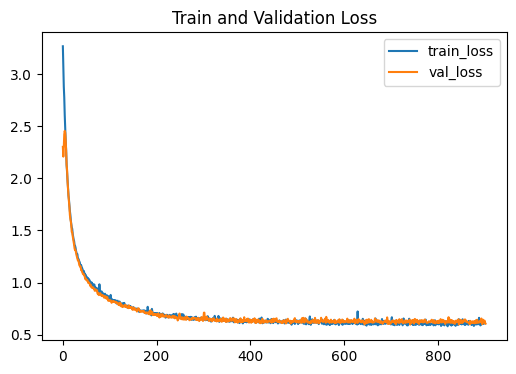

In [56]:
trainer.fit(cpc_classifier, train_dataloaders=train_loader, val_dataloaders=valid_loader)

## Classification evaluation

In [57]:
trainer.test(cpc_classifier, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.36it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7777777910232544
        test_loss           0.6797571182250977
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7777777910232544, 'test_loss': 0.6797571182250977}]

In [ ]:
classifier = StateClassifier(input_size=encoding_size, n_classes=n_classes)
tnc_classifier = TNC_Classifier(encoder, classifier)